# CIS680: Project 3: SOLO and FPN (Instance Segmentation)
### Due:
* Part (a) Oct. 17 at 11:59 p.m.
* Part (b) Oct. 24 at 11:59 p.m.

### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.
* You should expect that a complete training session should last about 6 hours, so you should start part (b) as early as you can!
* To save on compute time, we debugging locally and using colab to train.

## Code Structure
In this assignment, we are only providing the barest templates for your code structure. If you prefer, you can write and debug most of the components in a regular python and only use Jupyter to train. In this case, you might have several files that you import into this notebook, e.g.
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [ ]:
try:
    import dataset
    import model
    import train
    import inference
except ModuleNotFoundError:
    pass

## Notes to Grader

You can execute all of the following cells to reproduce the results.

## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>  

In this project, you are tasked with implementing an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>  

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this. You can find the dataset set here: https://drive.google.com/drive/folders/1eP7FtPaWfJ5zLdcsZYl6eyn5EYixkFn8

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the iamge to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [1]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, masks, bounding_boxes = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes

In [2]:
#################################################### dataset############################################
import h5py
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from random import randrange
from matplotlib import patches
import matplotlib.pyplot as plt

#我是直接下到本地 从本地 拿的数据， 这里你们估计要改成 colab 所对应的地址
mask_file = "hw3_mycocodata_mask_comp_zlib.h5"
image_file = "hw3_mycocodata_img_comp_zlib.h5"
bbx_file = "hw3_mycocodata_bboxes_comp_zlib.npy"
label_file = "hw3_mycocodata_labels_comp_zlib.npy"

def readData(file, file_type):
    if file_type == "h5":
        with h5py.File(file, "r") as f:
            a_group_key = list(f.keys())[0]
            data = np.array(list(f[a_group_key]))
    elif file_type == "npy":
        data = np.load(file, allow_pickle = True)
    return data


class ImageDataset(Dataset):
    def __init__(self, images, labels, masks, bbx, transform):
        self.labels = labels
        self.images = images
        self.masks = masks
        self.bbx = bbx
        self.transform = transform
        self.mask_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size = (800, 1066), interpolation=0),
            transforms.Pad(padding = (11, 0), fill = 0),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
#         while len(self.labels[idx]) == 0:
#             idx = idx - 1
        length_to = len(self.labels[idx])
        
        len_to_idx=0
        if idx > 0:
            l = self.labels[:idx].copy()
            len_to_idx = np.hstack(l).shape[0]
            
        image = self.images[idx]
        image = image.astype("uint8").transpose(1, 2, 0)
        image = self.transform(image)
        
        mask = self.masks[len_to_idx:len_to_idx + length_to].astype(np.uint8)
        # print(idx, len(mask), length_to, len_to_idx)
        res_masks = torch.stack([self.mask_transform(m * 255).squeeze() for m in mask], dim = 0)
        bbx = torch.tensor(self.bbx[idx] * 1066 / 400, requires_grad = False)
        label = torch.tensor(self.labels[idx], requires_grad = False)

        return image, label, res_masks, bbx
    
# 整个转换完的效果我和别人对过
data_transformer = transforms.Compose([                           
    # 我在这里使用 ToPILImage() 的原因是 Resize 的input type 要求是 PIL image
    transforms.ToPILImage(),
    transforms.Resize(size = (800, 1066)),
    transforms.Pad(padding = (11, 0), fill = 0),
    #这一步是实现 （0,255） to (0,1), 并把他 从新变为 tensor(因为 Normalize 需要 tensor 作为输入)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [3]:
image_dataSet = readData(image_file, "h5")
mask_dataSet = readData(mask_file, "h5")
label_dataset = readData(label_file, "npy")
bbx_dataset = readData(bbx_file, "npy")

In [4]:
split = 2612
split2 = 3082

train_dataset = ImageDataset(image_dataSet[:split], label_dataset[:split], mask_dataSet[:split2], bbx_dataset[:split], data_transformer)
val_dataset = ImageDataset(image_dataSet[split:], label_dataset[split:], mask_dataSet[split2:], bbx_dataset[split:], data_transformer)
train_loader = DataLoader(train_dataset, shuffle = True, batch_size = 4, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, shuffle = False, batch_size = 4, collate_fn = collate_fn)

# Dataset Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


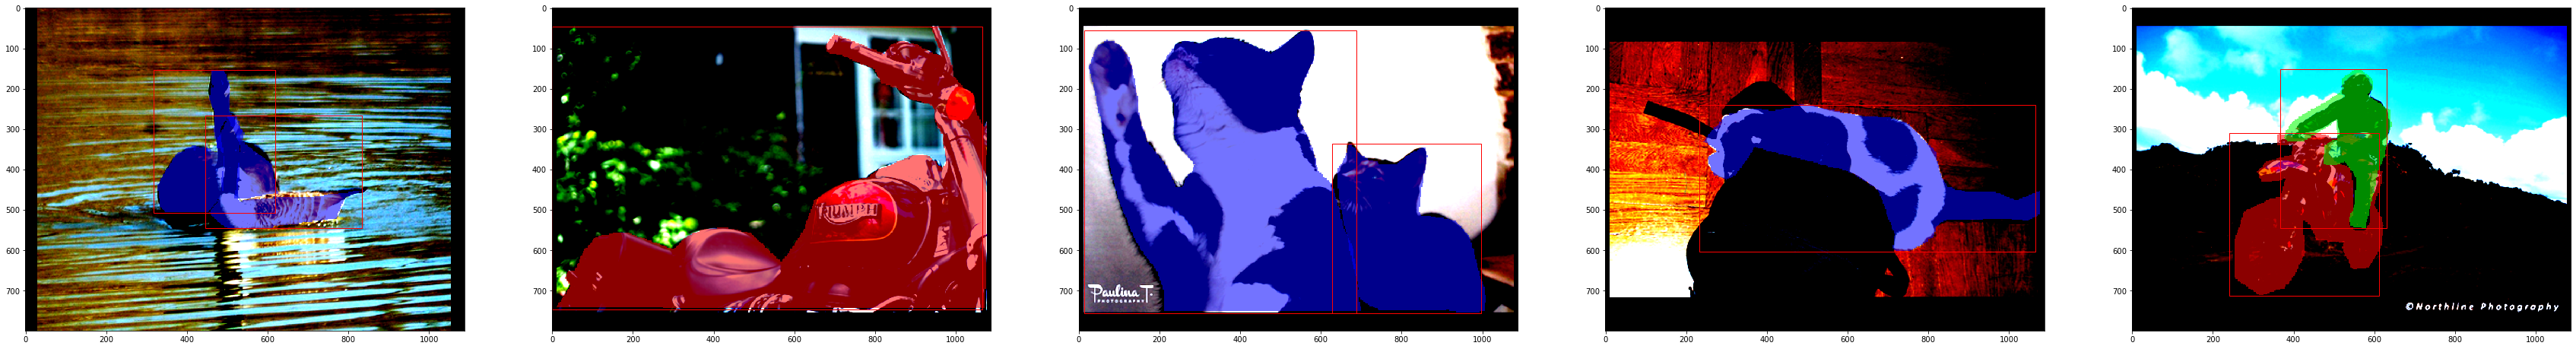

In [13]:
train_dataset = ImageDataset(image_dataSet[:split], label_dataset[:split], mask_dataSet[:split2], bbx_dataset[:split], data_transformer)
train_loader = DataLoader(train_dataset, shuffle = False, batch_size = 6, collate_fn = collate_fn)
img, label, mask, bbox = iter(train_loader).next()

def visualize(images, masks, bbxs, label):
    row = 1
    col = 5
    fig, ax = plt.subplots(row, col, figsize = (60, 40))

    for index in range(5):
        idx = index + 1
        l_ = label[idx].clone()

        if len(l_) > 1:
            ma = np.squeeze(mask[idx]).clone()
        else:
            ma = masks[idx].clone()


        it = 0
        i = np.transpose(images[idx], (1, 2, 0))
        ax[index].imshow(i)
        for l in l_:
            t=ma[it].clone()
            msk_3_c=np.zeros((t.shape[0],t.shape[1],4))
            msk = np.ma.masked_where(t == 0, t)
            indice=np.isnan(msk)
            msk[indice]=1.0
            msk_3_c[...,l.item()-1]=msk
            msk_3_c[...,3]=msk*0.55
            ax[index].imshow(msk_3_c)
            it = it + 1

        for box in bbxs[idx]:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor = 'r',
                                     facecolor = "none")
            ax[index].add_patch(rect)

    plt.show()

visualize(img, mask, bbox, label)

## Please note that we use RED: machine; GREEN: people; BLUE: animal!!!

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels are described in the "Forward" section. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.
 
#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

In [1]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Attempting uninstall: torch
    Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.8.0
    Uninstalling fsspec-0.8.0:
      Successfully uninstalled fsspec-0.8.0


ERROR: torchvision 0.6.1 has requirement torch==1.5.1, but you'll have torch 1.9.1 which is incompatible.
ERROR: tensorflow 1.14.0 has requirement tensorboard<1.15.0,>=1.14.0, but you'll have tensorboard 2.7.0 which is incompatible.


In [10]:
# import sys
# p = '/rds/projects/d/duanj-ai-in-medical-imaging/domain_adaptation/cv-power9/lib/python3.7/site-packages'
# if sys.path[0] != p:
#     sys.path.insert(0, p)

In [18]:
# for i in range(5):
#     print(mask_targets[i].shape)
# for i in range(5):
#     print(mask_predictions[i].shape)

torch.Size([5, 1600, 200, 272])
torch.Size([5, 1296, 200, 272])
torch.Size([5, 576, 100, 136])
torch.Size([5, 256, 50, 68])
torch.Size([5, 144, 50, 68])
torch.Size([5, 1600, 200, 272])
torch.Size([5, 1296, 200, 272])
torch.Size([5, 576, 100, 136])
torch.Size([5, 256, 50, 68])
torch.Size([5, 144, 50, 68])


# Target Assignment Visualizations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


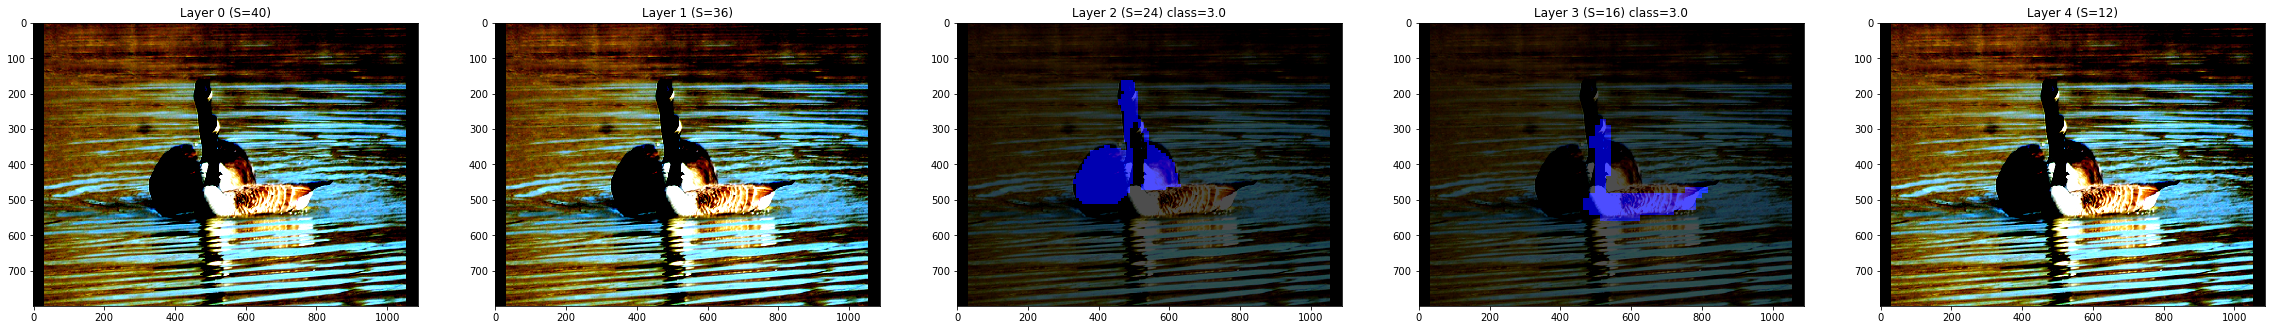

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


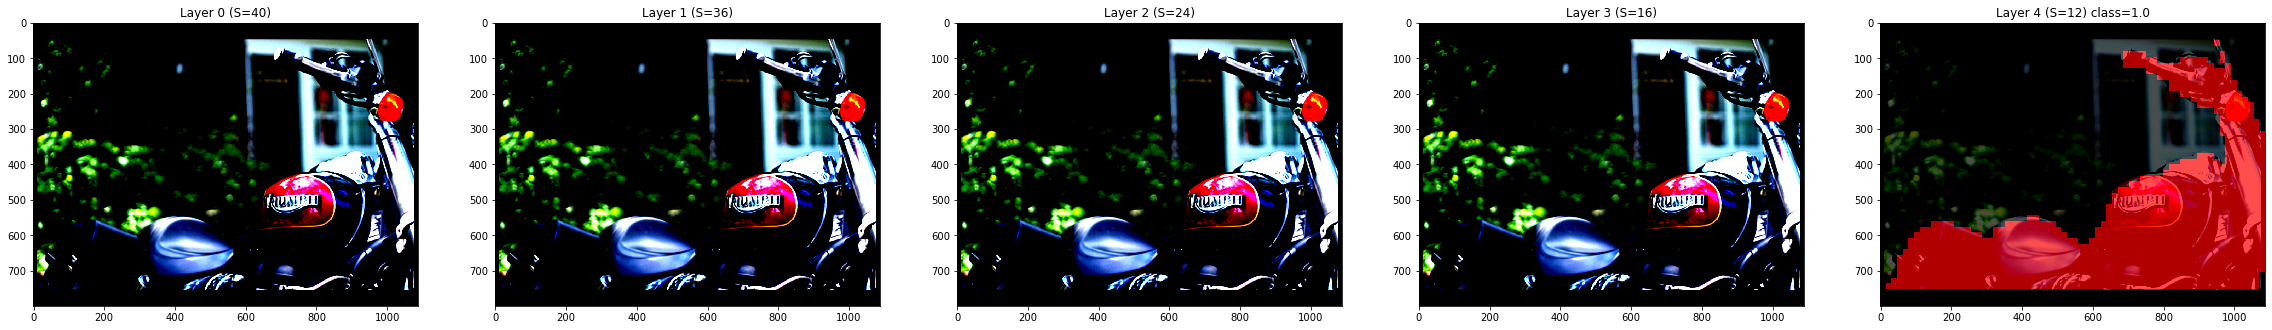

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


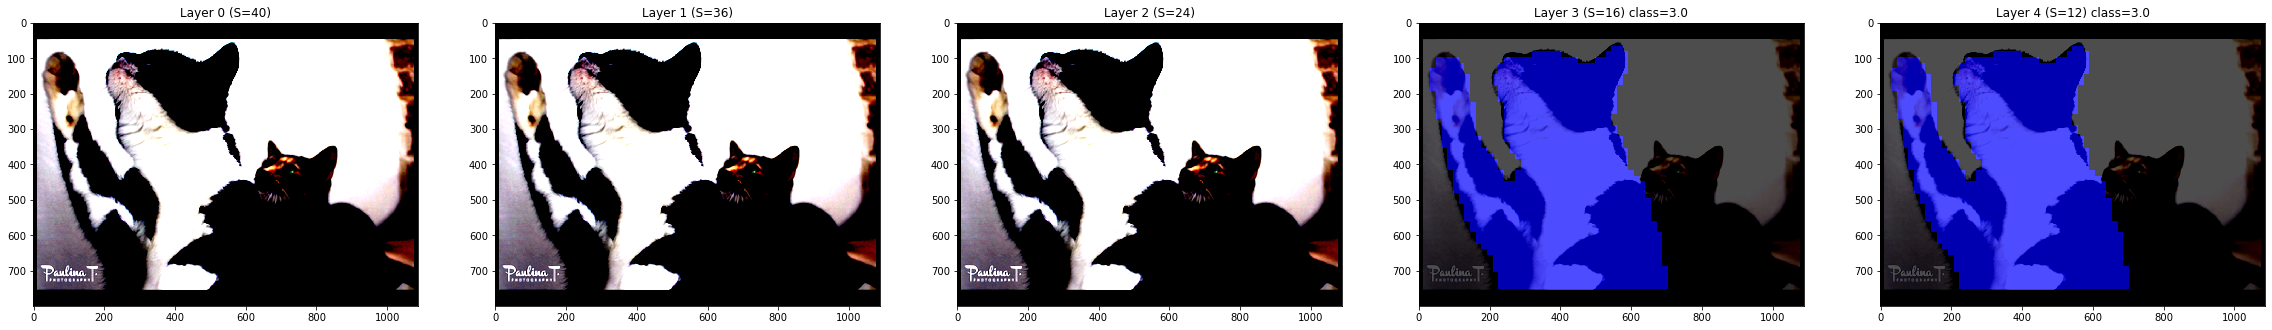

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


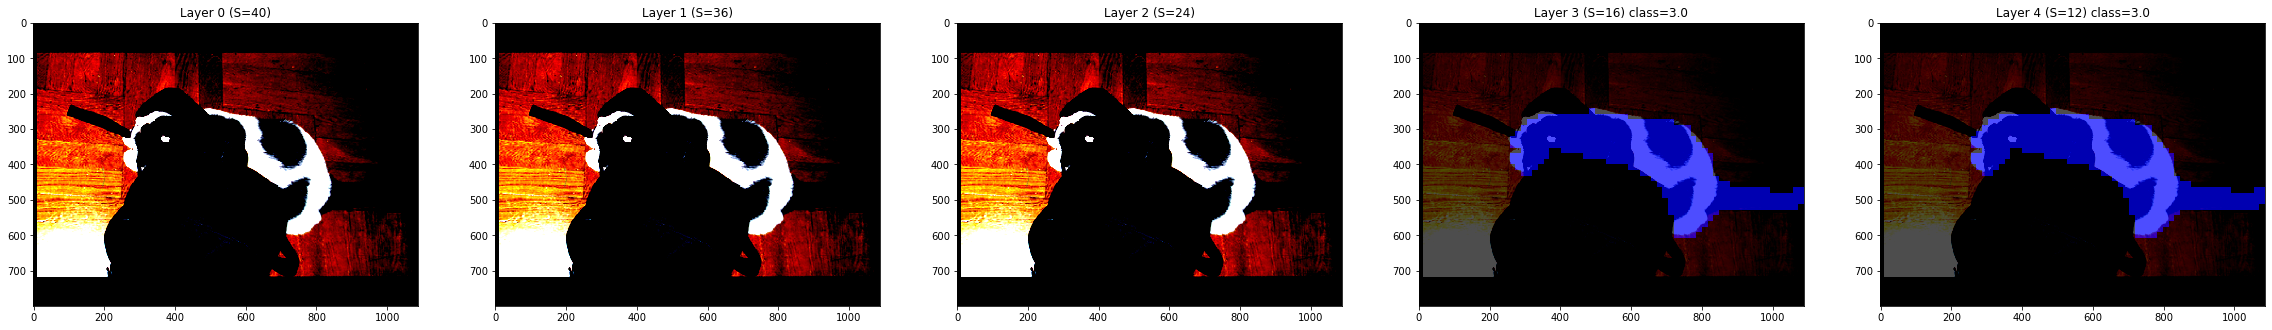

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


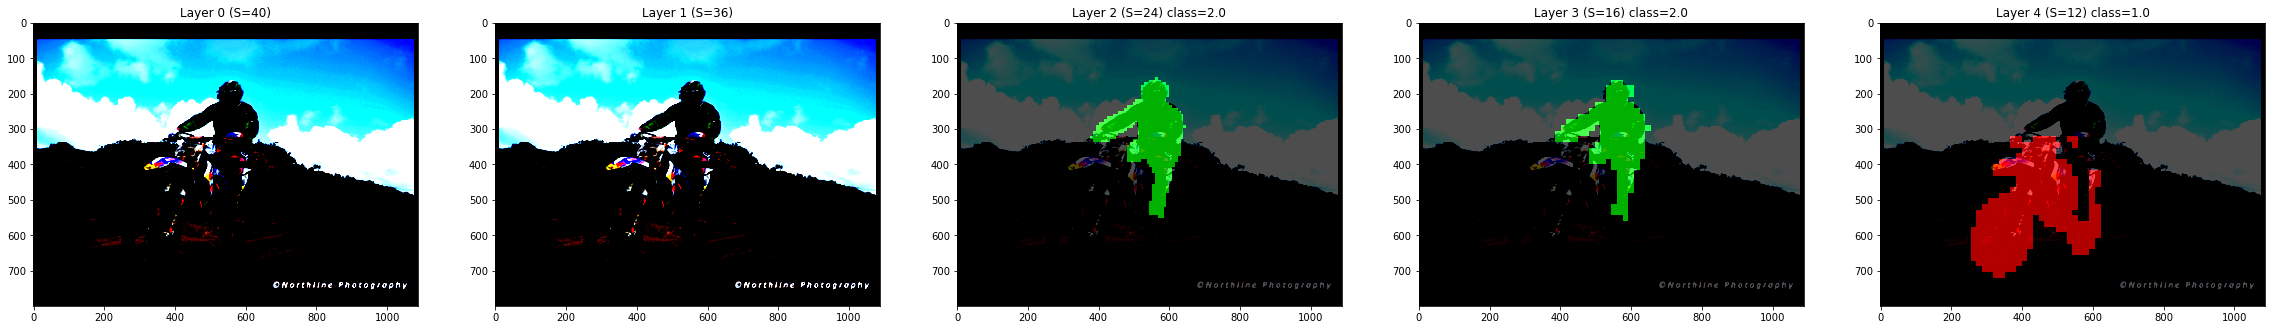

In [18]:
# Please execute the cell that defines SOLO() first (below)
# Notice that we have 2 objects in example 1 and 5.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDataset(image_dataSet[1:split], label_dataset[1:split], mask_dataSet[1:split2], bbx_dataset[1:split], data_transformer)
train_loader = DataLoader(train_dataset, shuffle = False, batch_size = 5, collate_fn = collate_fn)

model = SOLO()
images, labels, masks, bounding_boxes = iter(train_loader).next()
category_targets, mask_targets, active_masks = model.generate_targets(bounding_boxes, labels, masks)

for img_idx in range(5):

    fig, ax = plt.subplots(1, 5, figsize = (40, 8))

    for layer in range(5):
        # print(layer)
        ax[layer].imshow(images[img_idx].numpy().transpose((1, 2, 0)))
        ax[layer].title.set_text(f'Layer {layer} (S={model.num_grids[layer]})')

        i, j = torch.where(category_targets[layer][img_idx] > 0)
        k = torch.where(active_masks[layer][img_idx] == 1)[0]
        # print(i, j, k)
        if len(k) > 0:
            # We pick the first grid responsible for the object
            index = 17 if img_idx == 0 else 0
            cat = category_targets[layer][img_idx][i[index]][j[index]]
            color = torch.eye(3).to(device)[int(cat - 1)] * 255
            # print(color)
            mask = mask_targets[layer][img_idx][k[index]]
            mask = F.interpolate(mask.view(1, 1, *mask.size()), size=(800, 1088)).squeeze()
            mask = mask.unsqueeze(-1).repeat(1, 1, 3) * color

            ax[layer].imshow(mask.cpu(), alpha=0.7)
            ax[layer].title.set_text(f'Layer {layer} (S={model.num_grids[layer]}) class={cat}')

    plt.show()
    
del model

### Part A Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. Should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so.

## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.

In [5]:
# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

Image 1-5 are from validation set and 6-7 are from training set. We can verify that we implemented the algorithm correctly as it learn the training instances correctly both in terms of object location, outline, and classes. We can see that the mask generalizes well as it captures the basic outline on both training and validation set. However, class prediction is not ideal as it misclassifies on image 1, 2, and 4 and has a strong bias on class 2 (human).

There are two possibilities: (1) the data is imbalanced. (2) the category loss weight factor is not large enough. Possible improvements would be to (1) balance the dataset with sub-sampling or over-sampling and (2) increase the category loss weight factor

In [6]:
def loss_fn(cate_preds, cate_targets, mask_preds, mask_targets, active_mask):
    alpha = 0.25
    gamma = 2.
    total_lF = 0

    for f in range(5):
        #######################################
        ### Lcate
        ######################################
        c_prd = cate_preds[f].clone()
        c_tgt = cate_targets[f].clone()
        
        ThreeC_Fl = torch.zeros_like(c_prd[:, 0, :, :])
        S = c_prd.shape[2]
        C = c_prd.shape[1]
        # in each channel, see whether the target is the (idx+1) of channel
        # If yes treat at, pt, if not treat (1-at,1-pt)
        for c in range(3):
            c_prd_each_channel = c_prd[:, c, :, :]
            alpha_m = torch.ones_like(c_prd_each_channel) * (alpha)

            prd_t = torch.where(c_tgt == c + 1, c_prd_each_channel, 1 - c_prd_each_channel)
            alpha_t = torch.where(c_tgt == c + 1, alpha_m, 1 - alpha_m)

            Fl_each_channel = -alpha_t * torch.pow((1 - prd_t), gamma) * torch.log(prd_t + 0.00001)
            ThreeC_Fl += Fl_each_channel  # [2,S,S]

        ThreeC_Fl /= (S * S * C)
        S_2_SUM = torch.sum(ThreeC_Fl, (1, 2))  # [2]

        S_2_BATCH_SUM = torch.sum(S_2_SUM)  # [1]
        total_lF += S_2_BATCH_SUM

        #######################################
        ### Lmask
        ######################################
    Total_LD = 0

    for f in range(5):
        for b in range(len(mask_targets[0])):
            tgt = mask_targets[f][b].clone()
            prd = mask_preds[f][b].clone()
            act = active_mask[f][b].clone()

            count = torch.sum(act != 0)
            act = torch.squeeze(torch.nonzero(act))

            tgt = torch.index_select(tgt, 0, act)
            prd = torch.index_select(prd, 0, act)

            union = torch.sum(tgt ** 2) + torch.sum(prd ** 2)
            intersection = 2 * torch.sum(prd * tgt)
            L_Dice = (1 - intersection / union) / count

            if torch.isnan(L_Dice):
                L_Dice = 0
            Total_LD += L_Dice

    total_loss = total_lF + 3 * Total_LD
    return total_loss, total_lF, Total_LD

In [11]:
import pytorch_lightning as pl
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class SOLO(pl.LightningModule):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'layer_size': [(100, 136), (100, 136), (50, 68), (25, 34), (25, 34)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
    }
    
    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)
        self.train_loss = []
        self.train_focal = []
        self.train_dice = []
        self.val_loss = []
        self.val_focal = []
        self.val_dice = []
        
        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone
        
        self.conv6 = nn.Sequential(*[
            nn.Conv2d(256, 256, 3, stride=1, padding=1, bias=False),
            nn.GroupNorm(32, 256),
            nn.ReLU()
        ] * 6)
        
        self.conv7 = nn.Sequential(*[
            nn.Conv2d(256, 256, 3, stride=1, padding=1, bias=False),
            nn.GroupNorm(32, 256),
            nn.ReLU()
        ] * 7)
        
        self.cat_conv_out = nn.Sequential(
            nn.Conv2d(256, self.num_classes-1, 3, stride=1, padding=1, bias=True),
            nn.Sigmoid()
        )
        
        self.mask_conv1 = nn.Sequential(
            nn.Conv2d(256+2, 256, 3, stride=1, padding=1, bias=False),
            nn.GroupNorm(32, 256),
            nn.ReLU()
        )
        
        for S in self.num_grids:
            setattr(self, f'mask_conv_out_{S}', nn.Sequential(
                nn.Conv2d(256, S**2, 1, stride=1, padding=1, bias=True),
                nn.Sigmoid()
            ))
            
    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling
    def forward(self, images, eval=False):
        img_h, img_w = images.size()[-2:]
        # you can modify this if you want to train the backbone
        feature_pyramid = [v.detach() for v in self.backbone(images).values()] # this has strides [4,8,16,32,64]
        # change the stride via interpolation
        feature_pyramid[0] = torch.nn.functional.interpolate(feature_pyramid[0], size=feature_pyramid[1].size()[-2:])
        feature_pyramid[-1] = torch.nn.functional.interpolate(feature_pyramid[-1], size=feature_pyramid[-2].size()[-2:])
        # visualize the pyramid, this is where we got _default_cfg.layer_size
#         for v in feature_pyramid:
#             print(v.size())
        
        category_predictions = []
        mask_predictions = []
        for layer, x in enumerate(feature_pyramid):
            S = self.num_grids[layer]
            # align HxW to SxS
            y_cat = F.interpolate(x, size=(S, S))
            # category branch
            y_cat = self.conv7(y_cat)
            y_cat = self.cat_conv_out(y_cat)
            
            # CoordConv
            Hf, Wf = x.size()[-2:]
            range_x = torch.linspace(-1, 1, Hf, device=device)
            range_y = torch.linspace(-1, 1, Wf, device=device)
            coord = torch.meshgrid(range_x, range_y)
            coord = torch.stack(coord)
            coord = coord.unsqueeze(0).repeat(x.size(0), 1, 1, 1)
            
            y_mask = torch.cat([x, coord], dim=1)
            # mask branch
            y_mask = self.mask_conv1(y_mask)
            y_mask = self.conv6(y_mask)
            y_mask = getattr(self, f'mask_conv_out_{S}')(y_mask)
            # print(y_cat.size(), y_mask.size())
            
            if eval:
                y_mask = F.interpolate(y_mask, size=(int(img_h/4), int(img_w/4)), mode='bicubic')
            else:
                y_mask = F.interpolate(y_mask, size=(2*Hf, 2*Wf))
            
            category_predictions.append(y_cat)
            mask_predictions.append(y_mask)
            
        return category_predictions, mask_predictions
    
    def training_step(self, batch, batch_idx):
        images, labels, masks, bounding_boxes = batch
        category_targets, mask_targets, active_masks = self.generate_targets(bounding_boxes, labels, masks)
        category_predictions, mask_predictions = self(images)
        loss, focal, dice = loss_fn(category_predictions, category_targets, mask_predictions, mask_targets, active_masks)
        print(f'train epoch {len(self.train_loss) // 653}:{batch_idx}, {loss.item()}')

        self.train_loss.append(loss.item())
        self.train_focal.append(focal.item())
        self.train_dice.append(dice.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels, masks, bounding_boxes = batch
        category_targets, mask_targets, active_masks = self.generate_targets(bounding_boxes, labels, masks)
        category_predictions, mask_predictions = self(images)
        loss, focal, dice = loss_fn(category_predictions, category_targets, mask_predictions, mask_targets, active_masks)
        print(f'val epoch {len(self.train_loss) // 653}:{batch_idx}, {loss.item()}')
        
        self.val_loss.append(loss.item())
        self.val_focal.append(focal.item())
        self.val_dice.append(dice.item())
        return loss
    
    def configure_optimizers(self):
#         optimizer = torch.optim.SGD(self.parameters(), lr=0.025, momentum=0.9, weight_decay=1e-4)
#         def lr_fn(epoch):
#             if epoch < 26:
#                 return 1.
#             elif epoch < 32:
#                 return 0.1
#             else:
#                 return 0.01
#         lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_fn)
#         return {'optimizer': optimizer, 'scheduler': lr_scheduler}
        return torch.optim.Adam(self.parameters(), lr=1e-3)
        
    # This function build the ground truth tensor for each batch in the training
    # Input:
    #     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
    #     labels:           list, len(batch_size), each (n_object, )
    #     masks:            list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    #     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
    #     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2H_f, 2W_f)
    #     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)
    #     / boolean array with positive mask predictions
    def generate_targets(self, bounding_boxes, labels, masks):
        batch_size = len(bounding_boxes)
        num_fpn = len(self.scale_ranges)
        # initialize results
        category_targets = []
        mask_targets = []
        active_masks = []
        img_h, img_w = masks[0][0].size()

        for layer in range(num_fpn):
            S = self.num_grids[layer]
            scale_min, scale_max = self.scale_ranges[layer]
            Hf, Wf = self.layer_size[layer]

            cat_target = torch.zeros((batch_size, S, S), device=device)
            mask_target = torch.zeros((batch_size, S**2, 2*Hf, 2*Wf), device=device)
            active_mask = torch.zeros((batch_size, S**2), device=device)
            for img_idx, (img, label, mask) in enumerate(zip(bounding_boxes, labels, masks)):                
                for obj_idx, (obj_bb, obj_label, obj_mask) in enumerate(zip(img, label, mask)):
                    h, w = abs(obj_bb[2] - obj_bb[0]), abs(obj_bb[3] - obj_bb[1])
                    if sqrt(w*h) >= scale_min and sqrt(w*h) < scale_max:
                        # assign to this layer
                        cx, cy = torch.mean(torch.nonzero(obj_mask).float(), dim=0)
                        # find corner grids
                        i1 = max(int((cx - self.epsilon*h) / img_h * S), 0)
                        j1 = max(int((cy - self.epsilon*w) / img_w * S), 0)
                        i2 = min(int((cx + self.epsilon*h) / img_h * S), S-1)
                        j2 = min(int((cy + self.epsilon*w) / img_w * S), S-1)
                        # print(obj_idx, layer, (i1, j1, i2, j2))
                        # for each grid, convert category and mask to results
                        for i in range(i1, i2+1):
                            for j in range(j1, j2+1):
                                k = i*S + j
                                cat_target[img_idx, i, j] = int(obj_label)
                                mask_target[img_idx, k] = F.interpolate(obj_mask.view(1, 1, *obj_mask.size()).float(), size=(2*Hf, 2*Wf))
                                active_mask[img_idx, k] = 1
                
            category_targets.append(cat_target)
            mask_targets.append(mask_target)
            active_masks.append(active_mask)

        return category_targets, mask_targets, active_masks

In [ ]:
# First training for 36 epochs
model = SOLO()
trainer = pl.Trainer(gpus=1, max_epochs=36, progress_bar_refresh_rate=100, check_val_every_n_epoch=1)
trainer.fit(model, train_loader, val_loader)
torch.save(model.state_dict(), 'trained.pth')

## Discussion (Problem & Solution)

We found that using SGD with the recommended hyper-parameters is much slower in convergence compared to the Adam optimizer with default hyper-parameters (w/o weight decay, as suggested by some literature). Therefore, we adopted the later one.

We found that using Adam optimizer, the model converges very well already on epoch 10. After that, focal loss starts to increase. Therefore, we decided to retrain the model with only 10 epochs:

In [ ]:
model2 = SOLO()
trainer2 = pl.Trainer(gpus=1, max_epochs=11, progress_bar_refresh_rate=100, check_val_every_n_epoch=1)
trainer2.fit(model2, train_loader, val_loader)
torch.save(model2.state_dict(), 'trained2.pth')

In [ ]:
# model2 = SOLO()
# model2.load_state_dict(torch.load('trained2.pth'))
# model2.eval()
# model2 = model2.to(device)

# Inference Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


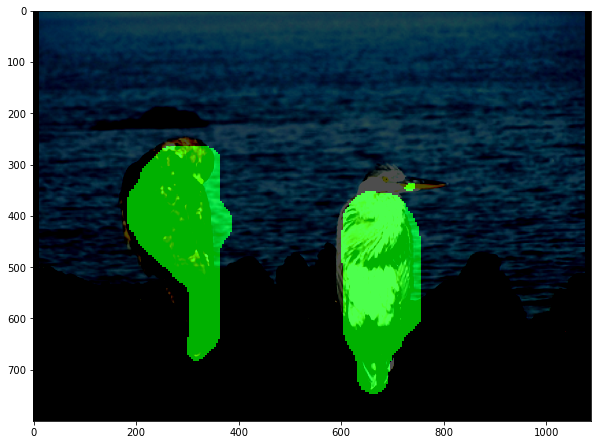

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


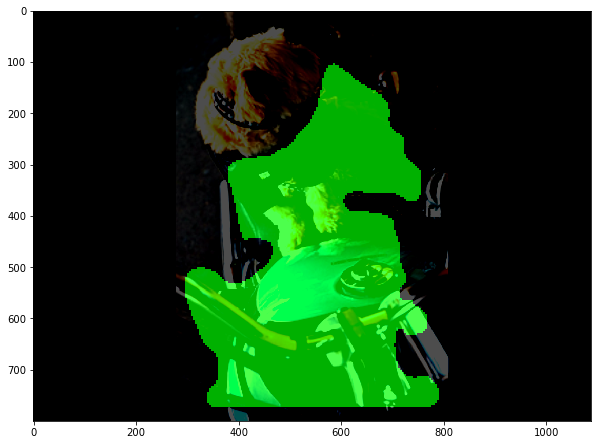

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


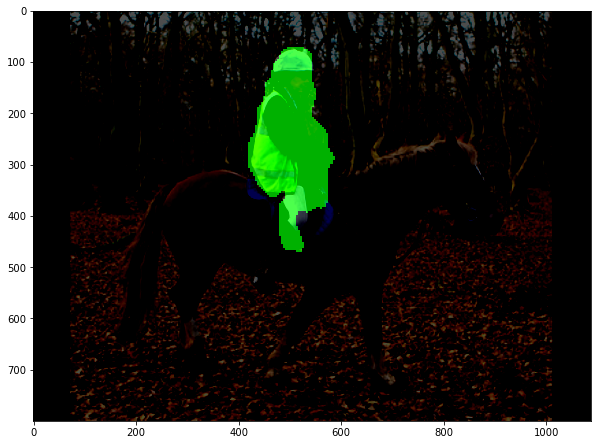

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


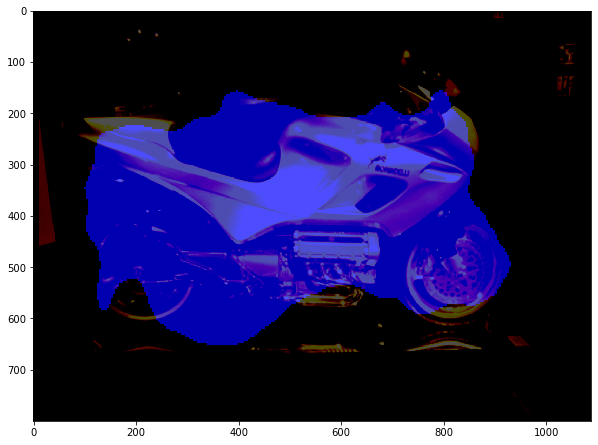

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


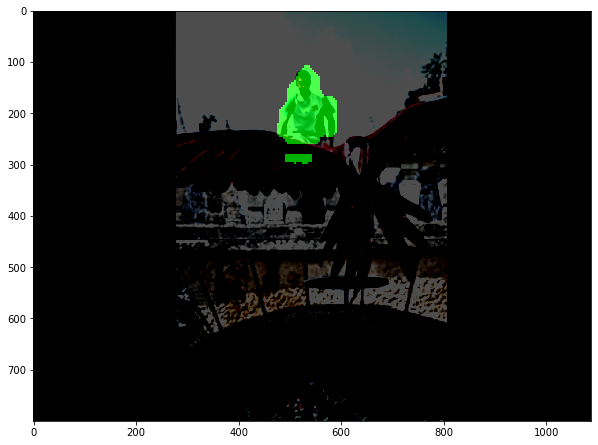

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


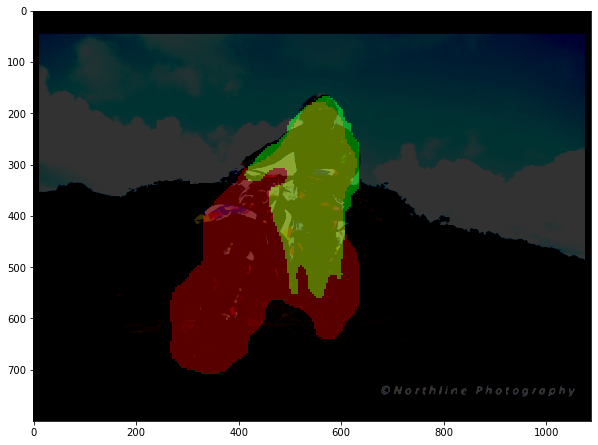

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


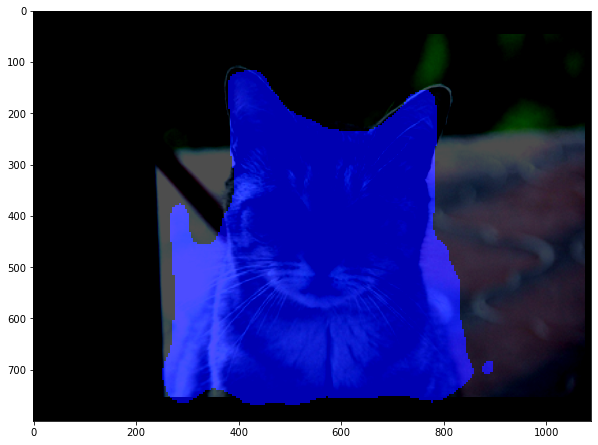

In [36]:
%matplotlib inline

def evaluate(images, labels, masks, bounding_boxes, model):
    category_targets, mask_targets, active_masks = model2.generate_targets(bounding_boxes, labels, masks)
    model = model.to(device)
    category_predictions, mask_predictions = model(images.to(device), eval=True)
    img_h, img_w = images.size()[-2:]
    num_fpn = 5
    n_classes = 3
    batch_size = category_predictions[0].size(0)
    # Low score NMS
    active_threshold = 0.3

    category_predictions = [points_nms(cp) for cp in category_predictions]
    category_predictions = [torch.cat([category_predictions[j][i].permute(1, 2, 0).view(-1, n_classes).clone() 
                             for j in range(num_fpn)]) for i in range(batch_size)]
    mask_predictions = [torch.cat([mask_predictions[j][i] 
                             for j in range(num_fpn)]) for i in range(batch_size)]

    for mp, cp, img in zip(mask_predictions, category_predictions, images):
        cp, cat = cp.max(dim=1)
        cp, indices = cp.sort(descending=True)
        active = cp > active_threshold
        cp = cp[active]
        mp = torch.round(mp[indices][active])
        cat = cat[active]

        scores = MatrixNMS(mp, cp)
        active2 = scores > active_threshold
        mp = mp[active2]
        cat = cat[active2]

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img.permute(1, 2, 0))
        for i, mask in enumerate(mp):
            color = torch.eye(3)[int(cat[i])] * 255
            mask = F.interpolate(mask.detach().cpu().view(1, 1, *mask.size()), size=(img_h, img_w))[0, 0]
            mask = mask.unsqueeze(-1).repeat(1, 1, 3) * color
            ax.imshow(mask, alpha=0.7 / (i + 1))
        plt.show()
        
    # Free cuda memory
    del mp, cp
    del category_targets, mask_targets, active_masks, images, labels, masks, bounding_boxes
    del category_predictions, mask_predictions
    torch.cuda.empty_cache()


offset = 20
val_dataset = ImageDataset(image_dataSet[split+offset:], label_dataset[split+offset:], mask_dataSet[split2+offset+1:], bbx_dataset[split+offset:], data_transformer)
val_loader = DataLoader(val_dataset, shuffle = False, batch_size = 3, collate_fn = collate_fn)

evaluate(*(iter(val_loader).next()), model2)

offset = 31
val_dataset = ImageDataset(image_dataSet[split+offset:], label_dataset[split+offset:], mask_dataSet[split2+offset+1:], bbx_dataset[split+offset:], data_transformer)
val_loader = DataLoader(val_dataset, shuffle = False, batch_size = 2, collate_fn = collate_fn)

evaluate(*(iter(val_loader).next()), model2)

offset = 5
train_dataset = ImageDataset(image_dataSet[offset:split], label_dataset[offset:split], mask_dataSet[offset:split2], bbx_dataset[offset:split], data_transformer)
train_loader = DataLoader(train_dataset, shuffle = False, batch_size = 2, collate_fn = collate_fn)

evaluate(*(iter(train_loader).next()), model2)

# Loss curves per iteration with 36 epochs:

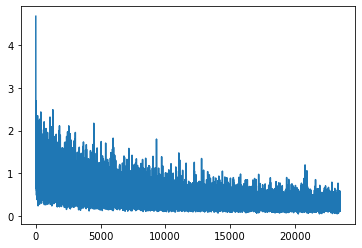

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(model.train_loss)
plt.show()

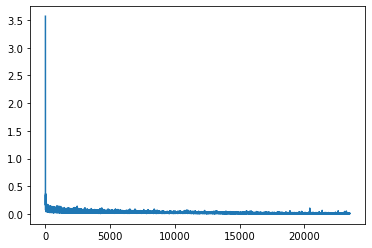

In [22]:
plt.plot(model.train_focal)
plt.show()

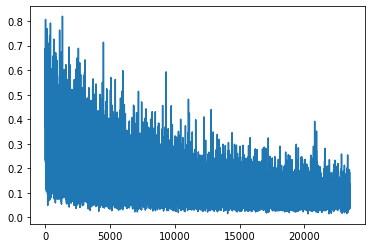

In [23]:
plt.plot(model.train_dice)
plt.show()

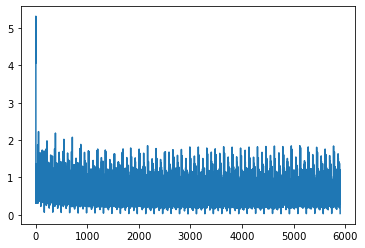

In [24]:
plt.plot(model.val_loss)
plt.show()

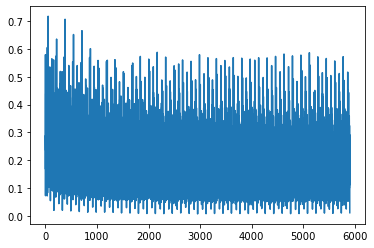

In [26]:
plt.plot(model.val_dice)
plt.show()

# Training loss curves per epoch with 36 epochs:

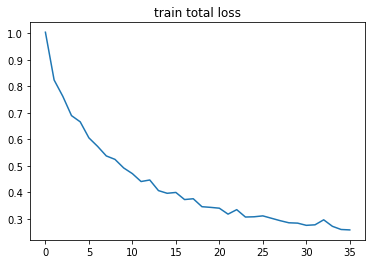

In [43]:
import numpy as np

plt.plot([np.mean(np.array(model.train_loss[i*635:(i+1)*635])) for i in range(36)])
plt.title('train total loss')
plt.show()

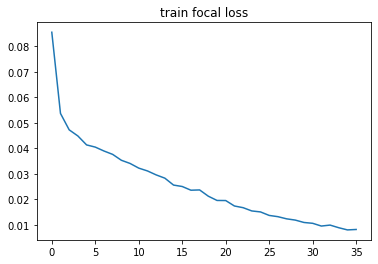

In [38]:
import numpy as np

plt.plot([np.mean(np.array(model.train_focal[i*635:(i+1)*635])) for i in range(36)])
plt.title('train focal loss')
plt.show()

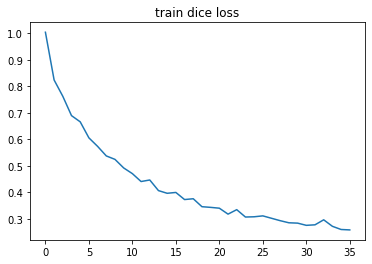

In [39]:
import numpy as np

plt.plot([np.mean(np.array(model.train_loss[i*635:(i+1)*635])) for i in range(36)])
plt.title('train dice loss')
plt.show()

# Validation loss curves per epoch with 10 epoch:

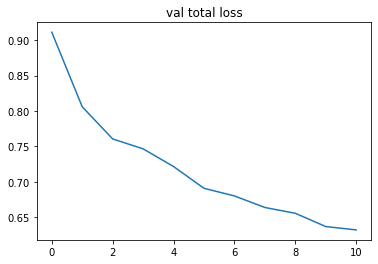

In [47]:
import numpy as np

plt.plot([np.mean(np.array(model2.val_loss[i*164:(i+1)*164])) for i in range(11)])
plt.title('val total loss')
plt.show()

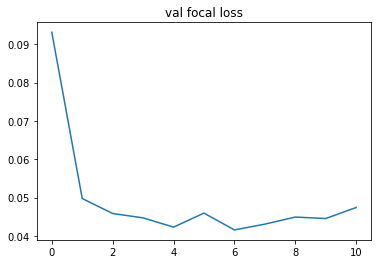

In [48]:
import numpy as np

plt.plot([np.mean(np.array(model2.val_focal[i*164:(i+1)*164])) for i in range(11)])
plt.title('val focal loss')
plt.show()

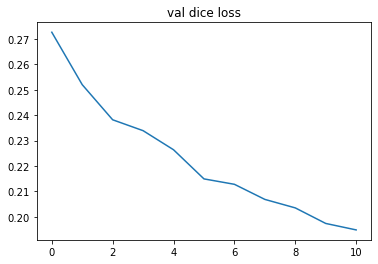

In [49]:
import numpy as np

plt.plot([np.mean(np.array(model2.val_dice[i*164:(i+1)*164])) for i in range(11)])
plt.title('val dice loss')
plt.show()

### Training
#### Optimizer
The SGD optimizer with a weight decay of 1e-4 and a momentum of 0.9 is used. For a batch size of 16, an initial learning rate of 16 is used (this should be scaled appropriately for different batch sizes). You should train for 36 epochs, reducing the learning rate by a factor of 10 at epochs 27 and 33.

#### Data Augemnetation
To achieve better performance, you may wish to explore some data augmentation techniques. You should be able to achieve the necessary performance without any augmentation, however.

#### Checkpointing
Due to the long training time, we highly recommend that you set up regular checkpointing during your training in case your training gets interrupted (e.g. your colab session ending).

## Team Division of Tasks

Shaoming Zheng: Target Assignment, Training, Post-processing (evaluation)

Yihui Mao: Data Visualization, Loss

Zhenglin Zhang: Target Assignment

### Part B Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Final inference results such as figs. 11-14. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Training and validation loss curves. These should include the focal loss, dice loss, and total loss as seperate quantities.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.

In addition, you should include a discussion of any issues you encountered during this project and any changes you made to the siggested architecture. If you made any interesting observations or thoughts about potential improvements, you should also include them here.

There will likely be a performance benchmark for this project - more details to be announced.